In [1]:
import math
import numpy as np
import mujoco, mujoco_viewer
import mediapy as media

from policy_infer import RealtimeController
from utils import quaternion_to_euler_array
from configs import env_cfg, cfg

In [2]:
model = mujoco.MjModel.from_xml_path(cfg.sim_config.mujoco_model_path)
data = mujoco.MjData(model)
# viewer = mujoco_viewer.MujocoViewer(model, data)

In [3]:
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()

# 设置相机的默认参数
mujoco.mjv_defaultFreeCamera(model, camera)

# 设置相机位置和目标点
camera.lookat[:] = [0, 0, 1]  # 设置相机观察的目标点 (x, y, z)
camera.distance = 2          # 设置相机到目标点的距离 d
camera.elevation = -10        # 垂直角度（向上或向下）
camera.azimuth = 135          # 水平角度（绕目标点旋转）

########################## body ##########################
['body_pitch', 'body_roll', 'body_yaw', 'left_ankle_pitch_link', 'left_ankle_roll_link', 'left_elbow_pitch_link', 'left_elbow_yaw_link', 'left_hip_pitch_link', 'left_hip_roll_link', 'left_hip_yaw_link', 'left_knee_pitch_link', 'left_shoulder_pitch_link', 'left_shoulder_roll_link', 'left_shoulder_yaw_link', 'left_wrist_pitch_link', 'left_wrist_roll_link', 'right_ankle_pitch_link', 'right_ankle_roll_link', 'right_elbow_pitch_link', 'right_elbow_yaw_link', 'right_hip_pitch_link', 'right_hip_roll_link', 'right_hip_yaw_link', 'right_knee_pitch_link', 'right_shoulder_pitch_link', 'right_shoulder_roll_link', 'right_shoulder_yaw_link', 'right_wrist_pitch_link', 'right_wrist_roll_link', 'world', 'x1-body']
########################## joint ##########################
['left_elbow_pitch', 'left_elbow_yaw', 'left_shoulder_pitch', 'left_shoulder_roll', 'left_shoulder_yaw', 'left_wrist_pitch', 'left_wrist_roll', 'right_elbow_pitch', 'right_elbow_yaw', 'right_shoulder_pitch', 'right_shoulder_roll', 'right_shoulder_yaw', 'right_wrist_pitch', 'right_wrist_roll']

In [4]:
mujoco.mj_forward(model, data)
data.body('right_wrist_roll_link').xpos

array([ 0.00233663, -0.19899706,  0.79393384])

In [5]:
data.joint('left_wrist_roll').qpos

array([0.])

In [6]:
# 设置机器人的目标关节位置
pi = np.pi
data.qpos = [ 1.3092, -1.1215, -0.0927,  0.1328,  2.0068, -1.5139,  0.6698, -0.6662,
        -1.3234,  0.8497,  0.2813, -0.8840, -0.4538, -0.8865]

# 保存目标关节位置
qpos0 = data.qpos.copy()

# 执行正向动力学计算，更新派生量（但不推进时间）
mujoco.mj_forward(model, data)

# 获取末端执行器的笛卡尔坐标位置
target = data.body('right_wrist_roll_link').xpos
print("Target =>", target)

Target => [ 0.41747242 -0.23979855  1.17487033]


In [7]:
# 重置仿真到关键帧 1，并获取初始状态的末端执行器位置
mujoco.mj_resetDataKeyframe(model, data, 1)  # 重置仿真数据到关键帧 1
mujoco.mj_forward(model, data)  # 更新派生量（但不推进时间）

In [8]:
# 获取初始位置并渲染场景
init_point = data.body('right_wrist_roll_link').xpos.copy()  # 获取初始点
renderer.update_scene(data, camera)  # 更新渲染场景
target_plot = renderer.render()  # 渲染初始状态图像

# 恢复目标关节配置，计算结果点并渲染场景
data.qpos = qpos0  # 恢复关节配置
mujoco.mj_forward(model, data)  # 更新派生量
result_point = data.body('right_wrist_roll_link').xpos.copy()  # 获取结果点
renderer.update_scene(data, camera)  # 更新渲染场景
result_plot = renderer.render()  # 渲染结果状态图像

# 打印初始点和目标点的位置
print("Initial point =>", init_point)
print("Desired point =>", result_point, "\n")

Initial point => [ 0.00233663 -0.19899706  0.79393384]
Desired point => [ 0.41747242 -0.23979855  1.17487033] 



Initial position,Desired end effector position

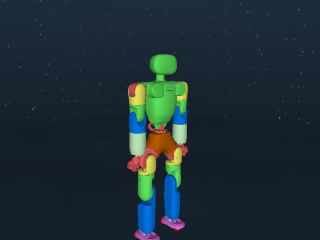
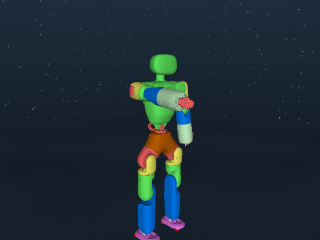

In [9]:
# 可视化结果
images = {
    'Initial position': target_plot,          # 初始位置图像
    'Desired end effector position': result_plot,  # 目标位置图像
}

media.show_images(images)  # 显示图像